# Data Cleaning and Preparation

In [6]:
import pandas as pd

# Replace with your actual path
df = pd.read_csv('marketing_AB.csv')

# Quick look
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [4]:
df.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [18]:
# Drop unnamed index column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [20]:
# Rename columns for easier use
df.rename(columns={
    'user id': 'user_id',
    'test group': 'group',
    'converted': 'converted',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
}, inplace=True)

In [22]:
# Drop duplicate user_ids, keeping the first
df.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [24]:
# Sanity check: any user in multiple groups?
group_check = df.groupby('user_id')['group'].nunique()
overlap = group_check[group_check > 1]
print(f"Users in both groups: {len(overlap)}")  # Expect 0

Users in both groups: 0


In [26]:
# Check missing values
missing_values = df.isnull().sum()

In [28]:
# Summary of cleaned data
summary = {
    'rows_after_cleaning': len(df),
    'columns': df.columns.tolist(),
    'missing_values': missing_values[missing_values > 0].to_dict()
}

summary

{'rows_after_cleaning': 588101,
 'columns': ['user_id',
  'group',
  'converted',
  'total_ads',
  'most_ads_day',
  'most_ads_hour'],
 'missing_values': {}}

In [171]:
df.to_excel("cleaned_marketing_data.xlsx", index=False)

# Basic Exploratory Data Analysis (EDA)

In [37]:
# Calculate conversion rates
conversion_rates = df.groupby('group')['converted'].mean().reset_index()

In [39]:
# Count of users in each group
group_counts = df['group'].value_counts()

In [33]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Set seaborn style
sns.set(style="whitegrid")

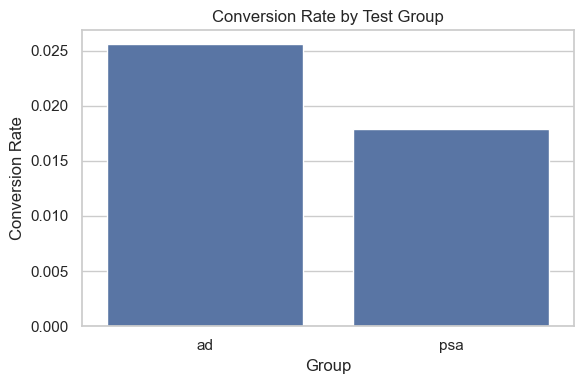

In [43]:
# Plot conversion rate by group
plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_rates, x='group', y='converted')
plt.title('Conversion Rate by Test Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.tight_layout()
plt.show()

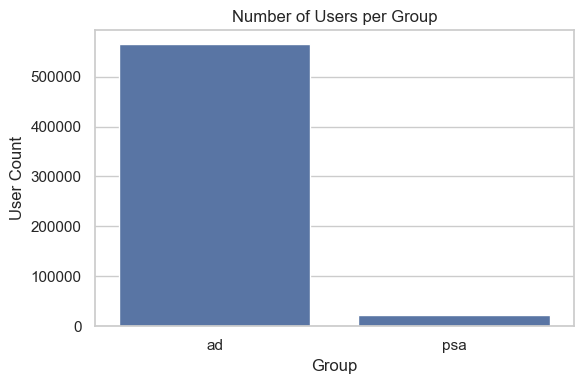

In [45]:
# Plot user count by group
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='group')
plt.title('Number of Users per Group')
plt.xlabel('Group')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()

In [47]:
# Calculate and return conversion metrics
conversion_stats = {
    'ad_group_conversion_rate': df[df['group'] == 'ad']['converted'].mean(),
    'holdout_group_conversion_rate': df[df['group'] == 'holdout']['converted'].mean(),
    'overall_conversion_rate': df['converted'].mean(),
    'group_counts': df['group'].value_counts().to_dict()
}

conversion_stats

{'ad_group_conversion_rate': 0.025546559636683747,
 'holdout_group_conversion_rate': nan,
 'overall_conversion_rate': 0.02523886203220195,
 'group_counts': {'ad': 564577, 'psa': 23524}}

# Statistical Significance Testing using SciPy

In [50]:
!pip install statsmodels openpyxl

In [62]:
from statsmodels.stats.proportion import proportions_ztest

In [64]:
# Print numeric stats
print("Conversion Rate (ad group): {:.2f}%".format(df[df['group'] == 'ad']['converted'].mean() * 100))
print("Conversion Rate (holdout group): {:.2f}%".format(df[df['group'] == 'holdout']['converted'].mean() * 100))
print("Overall Conversion Rate: {:.2f}%".format(df['converted'].mean() * 100))

Conversion Rate (ad group): 2.55%
Conversion Rate (holdout group): nan%
Overall Conversion Rate: 2.52%


In [70]:
# Conversion statistics
conversion_stats = {
    'ad_group_conversion_rate': df[df['group'] == 'ad']['converted'].mean(),
    'holdout_group_conversion_rate': df[df['group'] == 'holdout']['converted'].mean(),
    'overall_conversion_rate': df['converted'].mean(),
    'group_counts': df['group'].value_counts().to_dict()
}
print(conversion_stats)

{'ad_group_conversion_rate': 0.025546559636683747, 'holdout_group_conversion_rate': nan, 'overall_conversion_rate': 0.02523886203220195, 'group_counts': {'ad': 564577, 'psa': 23524}}


In [78]:
# Check counts per group
print("Group Counts:\n", df['group'].value_counts())

# Check conversion counts per group
print("\nConverted Sums:\n", df.groupby('group')['converted'].sum())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

Group Counts:
 group
ad     564577
psa     23524
Name: count, dtype: int64

Converted Sums:
 group
ad     14423
psa      420
Name: converted, dtype: int64

Missing Values:
 user_id          0
group            0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64


In [76]:
# Drop or fill missing values
df = df.dropna(subset=['converted'])  # safer in this context

In [80]:
print(df['group'].unique())

['ad' 'psa']


In [82]:
df['group'] = df['group'].replace({'psa': 'holdout'})

In [84]:
# Statistical Significance Test (Z-test)
success = [
    df[df['group'] == 'ad']['converted'].sum(),
    df[df['group'] == 'holdout']['converted'].sum()
]
nobs = [
    df[df['group'] == 'ad'].shape[0],
    df[df['group'] == 'holdout'].shape[0]
]

z_stat, p_val = proportions_ztest(count=success, nobs=nobs, alternative='larger')
print(f"Z-statistic: {z_stat:.4f}, p-value: {p_val:.4f}")

Z-statistic: 7.3701, p-value: 0.0000


# Interpretation
## Key Results:
- **Z-statistic**: 7.37 → indicates a large difference between groups.
- **P-value**: 0.0000 → well below the 0.05 threshold.
### *Conclusion*: The ad group outperforms the holdout group significantly.

## Business Recommendation:
The A/B test results show that the marketing ad campaign significantly increases user conversion compared to not showing ads. You should consider **rolling out the campaign to a broader audience** or **investing more in similar creative strategies**.

In [173]:
from scipy.stats import chi2_contingency
import pandas as pd

# Contingency table (example data)
data = [[40, 60],   # ad group: 40 converted, 60 not
        [30, 70]]   # control group: 30 converted, 70 not

chi2, p, dof, expected = chi2_contingency(data)

print(f"Chi²: {chi2:.4f}, p-value: {p:.4f}")

Chi²: 1.7802, p-value: 0.1821
